# Kiểm tra dữ liệu

## Cấu hình & import

In [1]:
!cp -r /kaggle/input/build-dataset-tt100k-tsd/tt100k_yolo /kaggle/working/
print("✅ Copied with system cp")

✅ Copied with system cp


In [2]:
import os, glob, random, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import os

DATA_ROOT = "/kaggle/working/tt100k_yolo"
SPLITS = ["train", "test"]

## Hàm tiện ích

In [3]:
def list_images_labels(split):
    img_dir = f"{DATA_ROOT}/images/{split}"
    lbl_dir = f"{DATA_ROOT}/labels/{split}"
    imgs = sorted(glob.glob(f"{img_dir}/*.jpg"))
    lbls = sorted(glob.glob(f"{lbl_dir}/*.txt"))
    return imgs, lbls

def read_label_file(path):
    with open(path, "r") as f:
        lines = [line.strip().split() for line in f.readlines() if line.strip()]
    return lines

## Kiểm tra tổng quan train/val

In [4]:
for split in SPLITS:
    imgs, lbls = list_images_labels(split)
    img_stems = {os.path.splitext(os.path.basename(p))[0] for p in imgs}
    lbl_stems = {os.path.splitext(os.path.basename(p))[0] for p in lbls}

    no_label = img_stems - lbl_stems
    orphan_lbl = lbl_stems - img_stems

    print(f"[{split.upper()}]")
    print(f"Ảnh: {len(imgs)} | Nhãn: {len(lbls)}")
    print(f"- Ảnh không có nhãn: {len(no_label)}")
    print(f"- Nhãn mồ côi: {len(orphan_lbl)}")
    print("-"*40)

[TRAIN]
Ảnh: 6034 | Nhãn: 6034
- Ảnh không có nhãn: 0
- Nhãn mồ côi: 0
----------------------------------------
[TEST]
Ảnh: 3022 | Nhãn: 3022
- Ảnh không có nhãn: 0
- Nhãn mồ côi: 0
----------------------------------------


🔍 Tìm thấy 6034 ảnh có nhãn trong train

🖼️ Hiển thị: 18387


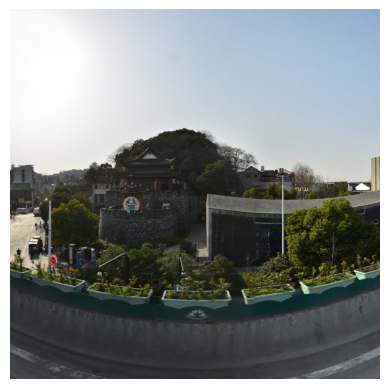


🖼️ Hiển thị: 96434


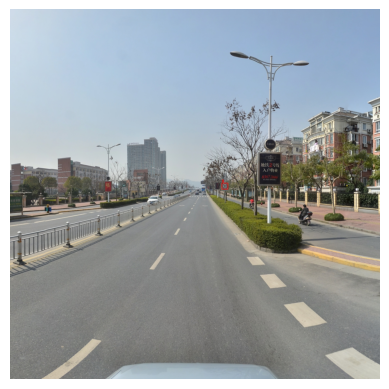


🖼️ Hiển thị: 48791


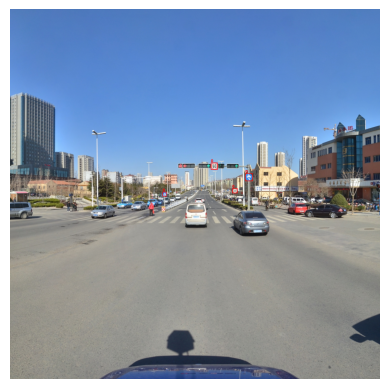

In [5]:
import cv2
import matplotlib.pyplot as plt

# --- Hàm đọc và visualize label YOLO ---
def visualize_yolo_image(img_path, label_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    if not os.path.exists(label_path):
        print(f"⚠️ Không có label cho {img_path}")
        return

    with open(label_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        cls, x, y, bw, bh = map(float, line.strip().split())
        x_center, y_center, bw, bh = x * w, y * h, bw * w, bh * h
        xmin = int(x_center - bw / 2)
        ymin = int(y_center - bh / 2)
        xmax = int(x_center + bw / 2)
        ymax = int(y_center + bh / 2)

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        cv2.putText(img, f"{int(cls)}", (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    plt.imshow(img)
    plt.axis("off")
    plt.show()


# --- Lấy 3 ảnh có nhãn ---
split = "train"
img_dir = os.path.join(DATA_ROOT, "images", split)
lbl_dir = os.path.join(DATA_ROOT, "labels", split)

labeled_imgs = [
    f for f in os.listdir(lbl_dir)
    if os.path.isfile(os.path.join(lbl_dir, f))
]

print(f"🔍 Tìm thấy {len(labeled_imgs)} ảnh có nhãn trong {split}")

for i in range(3):
    img_id = os.path.splitext(labeled_imgs[i])[0]
    img_path = os.path.join(img_dir, f"{img_id}.jpg")
    label_path = os.path.join(lbl_dir, f"{img_id}.txt")

    print(f"\n🖼️ Hiển thị: {img_id}")
    visualize_yolo_image(img_path, label_path)


In [6]:
import os
import yaml

DATA_ROOT = "//kaggle/working/tt100k_yolo"
OUT_YAML = "/kaggle/working/data.yaml"

# Lấy đường dẫn tuyệt đối của folder images/{split}
yaml_dict = {
    "path": DATA_ROOT,
    "train": os.path.join(DATA_ROOT, "images/train"),
    "val": os.path.join(DATA_ROOT, "images/test"),
    "nc": 1,
    "names": ["sign"]
}

# Ghi ra file YAML
with open(OUT_YAML, "w") as f:
    yaml.dump(yaml_dict, f, sort_keys=False)

print(f"✅ Tạo file data.yaml tại {OUT_YAML}")


✅ Tạo file data.yaml tại /kaggle/working/data.yaml


# Training model

## Định nghĩa hàm train_and_log()

In [7]:
!pip install -q ultralytics --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.4 MB/s eta 0:00:00


In [8]:
import time
import pandas as pd
from ultralytics import YOLO

def train_and_log(model_name, base_weights, data_yaml, save_dir, 
                  epochs=100, imgsz=640, batch=32):
    """
    Huấn luyện YOLO model và lưu lại kết quả huấn luyện cơ bản.
    
    Args:
        model_name (str): Tên mô hình (vd: YOLOv8n)
        base_weights (str): Đường dẫn file .pt gốc
        data_yaml (str): Đường dẫn file data.yaml
        save_dir (str): Thư mục lưu project YOLO
        epochs (int): Số epoch huấn luyện
        imgsz (int): Kích thước ảnh
        batch (int): Kích thước batch
        
    Returns:
        dict: Gồm các chỉ số mAP, Precision, Recall, thời gian huấn luyện, ...
    """
    start_time = time.time()
    
    model = YOLO(base_weights)
    results = model.train(
        data=data_yaml,
        epochs=epochs,
        imgsz=imgsz,
        batch=batch,
        mosaic=1.0,
        scale=0.5,
        copy_paste=0.1,
        hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,
        project=save_dir,
        name=model_name,
        workers=4,
        patience=10,
        verbose=False
    )
    
    elapsed = time.time() - start_time
    
    # Lấy metrics từ YOLO
    metrics = results.results_dict
    metrics.update({
        "Model": model_name,
        "Epochs": epochs,
        "ImgSize": imgsz,
        "Batch": batch,
        "TrainTime(min)": round(elapsed/60, 2)
    })
    
    print(f"✅ Hoàn tất {model_name} | "
          f"mAP50={metrics.get('metrics/mAP50(B)', 0):.4f} | "
          f"Precision={metrics.get('metrics/precision(B)', 0):.4f} | "
          f"Recall={metrics.get('metrics/recall(B)', 0):.4f} | "
          f"⏱ {elapsed/60:.2f} phút")
    
    return metrics

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Chuẩn bị file data.yaml

## Huấn luyện 3 model baseline

In [9]:
import pandas as pd

project_dir = "/kaggle/working/yolo_runs"

# 3 mô hình baseline
models = {
    "YOLOv5n": "yolov5n.pt",
    "YOLOv8n": "yolov8n.pt",
    "YOLO11n": "yolo11n.pt"
}

train_logs = []

for name, weights in models.items():
    print(f"\n Training {name} ...")
    m = train_and_log(
        model_name=name,
        base_weights=weights,
        data_yaml=OUT_YAML,
        save_dir=project_dir,
        epochs=30,
        imgsz=640,
        batch=32
    )
    train_logs.append(m)

# Lưu lại kết quả
df_results = pd.DataFrame(train_logs)
df_results.to_csv(f"{project_dir}/train_summary.csv", index=False)
print("\n✅ Saved summary:", f"{project_dir}/train_summary.csv")
display(df_results)


 Training YOLOv5n ...
PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Ultralytics 8.3.228 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, l

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       3022       8274      0.917      0.838      0.912      0.658
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /kaggle/working/yolo_runs/YOLOv5n
✅ Hoàn tất YOLOv5n | mAP50=0.9121 | Precision=0.9167 | Recall=0.8382 | ⏱ 89.40 phút

 Training YOLOv8n ...
Ultralytics 8.3.228 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, i

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       3022       8274      0.922      0.839      0.916      0.662
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /kaggle/working/yolo_runs/YOLOv8n
✅ Hoàn tất YOLOv8n | mAP50=0.9163 | Precision=0.9218 | Recall=0.8387 | ⏱ 88.97 phút

 Training YOLO11n ...
Ultralytics 8.3.228 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, i

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       3022       8274      0.916      0.846      0.916      0.661
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /kaggle/working/yolo_runs/YOLO11n
✅ Hoàn tất YOLO11n | mAP50=0.9164 | Precision=0.9156 | Recall=0.8456 | ⏱ 90.64 phút

✅ Saved summary: /kaggle/working/yolo_runs/train_summary.csv


,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),fitness,Model,Epochs,ImgSize,Batch,TrainTime(min)
0,0.916699,0.838168,0.912081,0.657514,0.657514,YOLOv5n,30,640,32,89.40
1,0.921761,0.838671,0.916324,0.661835,0.661835,YOLOv8n,30,640,32,88.97
2,0.915591,0.845579,0.916355,0.661338,0.661338,YOLO11n,30,640,32,90.64


In [10]:
!rm -rf /kaggle/working/tt100k_yolo